In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import pickle
from glob import glob
import os
import gc
from keras.preprocessing.image import load_img

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset

from model import UNetResNet34, predict_proba
#from model_classify_zero_mask import ZeroMaskClassifier, predict_proba

from utils import load_checkpoint
from dataset import pad_reflect, unpad_reflect, unpad_reflect256, TgsDataSet
from postprocess import rle_encode

from importlib import reload
import metrics
reload(metrics)
from metrics import *

from augmentation_huang import do_center_pad_to_factor

from sklearn.metrics import roc_auc_score

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

## post-process

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#device = torch.device("cpu")
#torch.set_num_threads(20)

img_size_target = 101#128,256

SEED = 6789#5678#4567#3456#2345#1234

In [5]:
# choose best threshold using validset
with open('../data/processed/dataset_%d.pkl'%SEED, 'rb') as f:
    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = pickle.load(f)

## select best_threshold for iou using valid dataset

In [6]:
# valid data & its flipped version
val_ds = TgsDataSet(x_valid, y_valid, transform=False)
val_dl = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

## x.shape = [1, 128, 128]
val_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_valid]), y_valid, transform=False)
val_dl_flip = DataLoader(
    val_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [7]:
# load the trained model
net = UNetResNet34(pretrained=True).cuda(device=device)
checkpoint_path = 'checkpoint/1010_all_mask_v1_seed%d/best.pth.tar'%SEED
net, _ = load_checkpoint(checkpoint_path, net)

In [8]:
net.set_mode('valid')
#preds_valid = (predict_proba(net, val_dl, device) + predict_proba(net, val_dl_flip, device)) / 2
preds_valid = (predict_proba(net, val_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, val_dl_flip, device)])) / 2

In [9]:
y_valid.shape, preds_valid.shape

((400, 1, 101, 101), (400, 256, 256))

In [10]:
y_valid = y_valid.reshape(-1, 101*101).sum(axis=1, keepdims=True)==0
preds_valid = np.array([unpad_reflect256(image) for image in preds_valid])

/home/endi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/endi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


/home/endi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  



[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.9220786  0.93284994 0.93836696
 0.93631778 0.93747373 0.94067886 0.94388398 0.94388398 0.9418348
 0.94299075 0.94299075 0.94299075 0.94299075 0.94299075 0.94299075
 0.94094157 0.94094157 0.93684321 0.93479403 0.93594998 0.93594998
 0.93594998 0.93594998 0.93915511 0.93915511 0.93710593 0.93710593
 0.93710593 0.93505675 0.93505675 0.93300757 0.93300757 0.93300757
 0.93300757 0.93300757 0.93300757 0.93300757 0.93095839 0.93095839
 0.92890921 0.92890921 0.92890921 0.92686003 0.9268

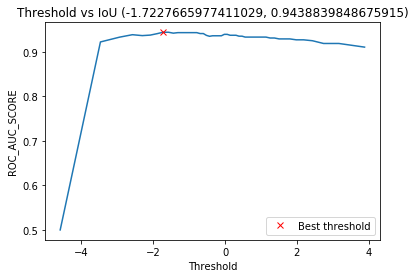

In [11]:
thresholds_ori = np.linspace(-1.0, 1.0, 100)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori))

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)

aucs = np.array([roc_auc_score(y_valid, (preds_valid > threshold).reshape(-1, 101*101).sum(axis=1, keepdims=True)==0) \
                 for threshold in tqdm_notebook(thresholds)])
print(aucs)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(aucs) 
auc_best = aucs[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, aucs)
plt.plot(threshold_best, auc_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("ROC_AUC_SCORE")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, auc_best))
plt.legend()

In [12]:
threshold_best, auc_best

(-1.7227665977411029, 0.9438839848675915)

## using best threshold to predict

In [13]:
## create testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [81]:
# with open('../data/processed/testset%d.pkl'%SEED, 'wb') as f:
#     pickle.dump([img_ids, x_test], f)

In [14]:
# for testset, also predict raw & flipped version, then average
#x_test_arr = np.array(list(map(pad_reflect, x_test)))
x_test_arr = np.array(x_test).reshape(18000, 1, 101, 101) #if use Huang's augmentation, otherwise comment this line
y_test = np.zeros(shape=(18000, 1, 101, 101))

test_ds = TgsDataSet(x_test_arr, y_test, transform=False)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

test_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_test_arr]), y_test, transform=False)
test_dl_flip = DataLoader(
    test_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [15]:
%%time

#preds_test = predict_proba(net, test_dl, device)

net.set_mode('test')
#preds_test = (predict_proba(net, test_dl, device) + predict_proba(net, test_dl_flip, device)) / 2
preds_test = (predict_proba(net, test_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, test_dl_flip, device)])) / 2

CPU times: user 2h 4min, sys: 58min 54s, total: 3h 2min 54s
Wall time: 12min 39s


In [16]:
# saving
with open('prediction/1010_all_mask_v1_seed%d.pkl'%SEED, 'wb') as f:
    pickle.dump([preds_test, threshold_best], f, protocol=4)

In [16]:
# 
#is_zero_mask = (preds_test > threshold_best).astype(int).reshape(-1,)

_preds_test = np.array([unpad_reflect256(image) for image in preds_test])
is_zero_mask = (_preds_test > threshold_best).reshape(-1, 101*101).sum(axis=1, keepdims=True)==0

sub = pd.DataFrame({'id': img_ids, 'is_zero_mask': is_zero_mask.reshape(-1)})

In [17]:
sub.is_zero_mask.sum()

7015

In [18]:
sub.to_csv('../submissions/1010_849model_all_mask_predict_zero_mask_seed3456.csv.gz', index=False, compression='gzip')

## blend zero-mask models (train with all images)

In [4]:
## create testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [5]:
def check_pred_is_zero_mask(preds_test):
    preds_test = np.array([unpad_reflect256(_preds_test) for _preds_test in tqdm_notebook(preds_test)])
    is_zero_mask = (preds_test > threshold_best).reshape(-1, 101*101).sum(axis=1, keepdims=True)==0
    return is_zero_mask.reshape(-1).astype(np.int)

In [6]:
# 合并N个fold的预测（0-1），用户voting方式blending
is_zero_mask_blend = None

for seed in [1234, 2345, 3456, 4567, 5678]:
    with open('prediction/1010_all_mask_v1_seed%d.pkl'%seed, 'rb') as f:
        preds_test, threshold_best = pickle.load(f)
    is_zero_mask = check_pred_is_zero_mask(preds_test)
    if is_zero_mask_blend is None:
        is_zero_mask_blend = is_zero_mask
    else:
        is_zero_mask_blend += is_zero_mask
    del preds_test
    gc.collect()

In [8]:
N = 2

sub = pd.DataFrame({'id': img_ids, 'is_zero_mask': is_zero_mask_blend > N})

sub.is_zero_mask.sum()

7279

In [21]:
sub.to_csv('../submissions/1010_849model_all_mask_predict_zero_mask_seed1234_2345_3456_4567_5678_blend.csv.gz', index=False, compression='gzip')

In [40]:
model0_preds = sub.loc[sub.is_zero_mask.values.astype(bool), 'id'].tolist()
mode11_preds = zero_mask_ids

In [43]:
len(np.intersect1d(model0_preds, mode11_preds))

7400

In [45]:
final_zero_ids = np.intersect1d(model0_preds, mode11_preds)

In [48]:
with open('../submissions/pred_zero_mask_img_ids.pkl', 'wb') as f:
    pickle.dump(final_zero_ids, f, protocol=4)